In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import sys
import os
original_stdout = sys.stdout

# Redirect stdout to devnull
sys.stdout = open(os.devnull, 'w')

!pip install constants craft-text-detector paddleocr paddlepaddle

from transformers import TrOCRProcessor
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import re
# import constants
import requests
import pandas as pd
import multiprocessing
import time
from time import time as timer
from tqdm import tqdm
from pathlib import Path
from functools import partial
import urllib
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
# from craft_text_detector import Craft
from tqdm import tqdm
from torchvision import transforms
# from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import cv2
import easyocr
import requests
from PIL import Image
from io import BytesIO
from paddleocr import PaddleOCR
from skimage.filters import threshold_local

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
dataTrain = pd.read_csv('/kaggle/input/dataset/train.csv')
dataTest = pd.read_csv('/kaggle/input/dataset/test.csv')

sys.stdout = original_stdout  #Resume printing 

In [2]:
len(dataTest)

131187

In [ ]:
print(dataTrain.entity_name.unique())
print(len(dataTrain.group_id.unique()))
print(dataTrain.entity_name.value_counts())

In [2]:
class ProductImageDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.df.iloc[idx]['image_link'].split('/')[-1])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        group_id = self.df.iloc[idx]['group_id']
        entity_value = self.df.iloc[idx]['entity_value']
        entity_name = self.df.iloc[idx]['entity_name']
        return image, group_id,entity_name, entity_value

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class EntityValuePredictor(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased'):
        super(EntityValuePredictor, self).__init__()
        
        # Load BERT for embedding text inputs
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.tokenizer = BertTokenizer.from_pretrained(bert_model_name)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.bert.config.hidden_size * 2 + 1, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)  # Predict a single value (entity_value)
        self.relu = nn.ReLU()

    def forward(self, ocr_text, group_id, entity_name):
        # Tokenize the text inputs
        ocr_inputs = self.tokenizer(ocr_text, return_tensors='pt', padding=True, truncation=True)
        entity_inputs = self.tokenizer(entity_name, return_tensors='pt', padding=True, truncation=True)
        
        # Get BERT embeddings
        ocr_embedding = self.bert(**ocr_inputs)['pooler_output']
        entity_embedding = self.bert(**entity_inputs)['pooler_output']
        
        # Embed the group_id
        
        group_id_embed = torch.tensor(group_id, dtype=torch.int32).unsqueeze(dim=0).unsqueeze(dim=0)
        # Concatenate embeddings
        combined_input = torch.cat([ocr_embedding, entity_embedding, group_id_embed], dim=1)
        print(f'Comb: {combined_input.shape}')
        # Fully connected layers for prediction
        x = self.relu(self.fc1(combined_input))
        x = self.relu(self.fc2(x))
        entity_value = self.fc3(x)
        
        return entity_value

In [3]:
file_path = '/opt/conda/lib/python3.10/site-packages/craft_text_detector/models/basenet/vgg16_bn.py'

# Read in the file
with open(file_path, 'r') as file:
    filedata = file.read()

# Replace the incorrect import statement
filedata = filedata.replace("from torchvision.models.vgg import model_urls", "")
# filedata = filedata.replace("model_urls['vgg16_bn'] = model_urls['vgg16_bn'].replace('https://', 'http://')",'')
# filedata = filedata.replace('model_urls["vgg16_bn"] = model_urls["vgg16_bn"].replace("https://", "http://"','')

# Write the file out again
with open(file_path, 'w') as file:
    file.write(filedata)
    

txt = """
all = [
'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
'vgg19_bn', 'vgg19',
]

model_urls = {
'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}
"""
with open(file_path, 'a') as file:
    file.write(txt)
    
    
file_path = '/opt/conda/lib/python3.10/site-packages/craft_text_detector/craft_utils.py'

with open(file_path, 'r') as file:
    filedata = file.read()
    
filedata = filedata.replace("polys = np.array(polys)", "polys = np.array(polys, dtype=object)")

with open(file_path, 'w') as file:
    file.write(filedata)

file_path = '/opt/conda/lib/python3.10/site-packages/craft_text_detector/predict.py'

with open(file_path, 'r') as file:
    filedata = file.read()
    
filedata = filedata.replace("polys_as_ratio = np.array(polys_as_ratio)", "polys_as_ratio = np.array(polys_as_ratio, dtype=object)")

with open(file_path, 'w') as file:
    file.write(filedata)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from craft_text_detector import Craft
# from transformers import TrOCRProcessor, VisionEncoderDecoderModel

craft = Craft(output_dir=None, crop_type="box", cuda=True)
reader = easyocr.Reader(['en'], gpu=True)
# paddle_ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=True)
# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

Craft text detector weight will be downloaded to /root/.craft_text_detector/weights/craft_mlt_25k.pth


Downloading...
From: https://drive.google.com/uc?id=1bupFXqT-VU6Jjeul13XP7yx2Sg5IHr4J
To: /root/.craft_text_detector/weights/craft_mlt_25k.pth
100%|██████████| 83.2M/83.2M [00:01<00:00, 80.7MB/s]


Craft text refiner weight will be downloaded to /root/.craft_text_detector/weights/craft_refiner_CTW1500.pth


Downloading...
From: https://drive.google.com/uc?id=1xcE9qpJXp4ofINwXWVhhQIh9S8Z7cuGj
To: /root/.craft_text_detector/weights/craft_refiner_CTW1500.pth
100%|██████████| 1.85M/1.85M [00:00<00:00, 155MB/s]


In [15]:
imageNames = set(os.listdir('/kaggle/input/imagestrain/sampleTrain'))
def extract_image_name(image_link):
    return image_link.split('/')[-1]

df = dataTrain.copy()

# Apply the function to create a new column with the extracted image names
df['image_name'] = df['image_link'].apply(extract_image_name)
# Filter rows where the image_name is in the images_in_folder set
df = df[df['image_name'].isin(imageNames)]

In [9]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()  # Convert PIL image to PyTorch Tensor
])

image_dir = '/kaggle/input/imagestrain/sampleTrain'
output_dir = '/kaggle/working/output'
train_dataset = ProductImageDataset(df, image_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# model = EntityValuePredictor()

In [6]:
from PIL import Image, ImageDraw
from math import atan2, degrees

def extract_structured_text3(image):
#     image = preprocess_image3(image)
#     print(f'Image: {image.shape}')
    prediction_result = craft.detect_text(image)
#     debug_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
#     debug_image = Image.fromarray(image)
#     draw = ImageDraw.Draw(debug_image)
    structured_text = []
    boxes = prediction_result["boxes"]
    for box in boxes:
#         draw.polygon([tuple(point) for point in box], outline=(255, 0, 0), width=5)
        roi = get_cropped3(image, box)
#         angle = get_box_rotation_angle3(box)
#         if angle != 0:
# #             print(f'Angle:{angle}')
#             roi = get_rotated_roi3(image,box,angle)
#         text = extract_text_from_roi(roi)
#         text = pytesseract.image_to_string(img, lang='eng')
        result = reader.readtext(np.array(roi))
        if result:
#             draw.text((box[0][0], box[0][1] - 10), result, fill=(0, 255, 0))
            structured_text.append(result[0][1])
        
#         text = paddle_ocr.ocr(np.array(roi), rec=True)
#         if text:
# #             text = [entry[1][0] for entry in text]  # Get the recognized text only
# #             structured_text.extend(text)  # Add to the structured text list
#             draw.text((box[0][0], box[0][1] - 10), text, fill=(0, 255, 0))
#             for result in text:
#                 if result:
#                     for line in result:
#                         if line:
#                             text = line[1][0]  # Extracting text
#                             structured_text.append(text)  # Collecting recognized text
    return filterNum3(structured_text)

def contains_numbers3(string):
    return any(char.isdigit() for char in string)

def filterNum3(rowRes):
    temp = []
    for r in rowRes:
#         for s in r:
        if contains_numbers3(r):
            temp.append(r)
    return temp

# def get_rotation_angle(box):
#     """Calculates the rotation angle of the box."""
#     print(f'Box: {box}')
#     p1, p2 = box[0], box[1]  # Taking two points of the box
#     angle = atan2(p2[1] - p1[1], p2[0] - p1[0])
#     return degrees(angle)

# def rotate_image(image, angle):
#     """Rotates the image by the given angle."""
# #     pil_img = Image.fromarray(np.array(image))
#     image = image.rotate(angle, expand=True)
#     return image

def get_rotated_roi3(image, box, angle):
    """Extracts and rotates the region of interest from the image."""
    # Get the four points of the box
    rect = cv2.minAreaRect(np.int0(box))
    box_points = cv2.boxPoints(rect)
    box_points = np.int0(box_points)
    
    # Apply affine transformation to correct rotation
    width = int(rect[1][0])
    height = int(rect[1][1])
    src_pts = box_points.astype("float32")
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(image, M, (width, height))
    
    return Image.fromarray(warped).convert('RGB')

def get_box_rotation_angle3(box):
    """Calculates the rotation angle of the box using all four points."""
    # Calculate angle from first two points (this will handle rotations better)
    rect = cv2.minAreaRect(np.int0(box))
    angle = rect[-1]  # Angle returned by minAreaRect
    if angle < -45:
        angle += 90
    return angle

def preprocess_image3(image):
    """ Preprocessing steps: scaling, rotation, denoising, and contrast enhancement """
    # Convert image to grayscale
    min_size = 1500  # You can adjust this value
    h, w = image.shape[:2]
    if max(h, w) < min_size:
        scale = min_size / max(h, w)
        image = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
#     image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
# #     # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     image = clahe.apply(image)
#     image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

# def get_rotated_roi(image, box):
#     rect = cv2.minAreaRect(np.array(box[0]).astype(np.float32))
#     angle = rect[2]
#     rows, cols = image.shape[0], image.shape[1]
#     M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
#     rotated_image = cv2.warpAffine(image, M, (cols, rows))
    
#     box = cv2.boxPoints(rect)
#     box = np.int0(box)
    
#     width = int(rect[1][0])
#     height = int(rect[1][1])
#     src_pts = box.astype("float32")
#     dst_pts = np.array([[0, height-1], [0, 0], [width-1, 0], [width-1, height-1]], dtype="float32")
#     M = cv2.getPerspectiveTransform(src_pts, dst_pts)
#     warped = cv2.warpPerspective(rotated_image, M, (width, height))
    
#     return Image.fromarray(warped).convert('RGB')

def get_cropped3(image, box):
    box = np.int0(box)
    x_min = np.min(box[:, 0])
    y_min = np.min(box[:, 1])
    x_max = np.max(box[:, 0])
    y_max = np.max(box[:, 1])
    
    # Crop the region of interest
    cropped_roi = image[y_min:y_max, x_min:x_max]
    
    return Image.fromarray(cropped_roi).convert('RGB')

In [7]:
def extract_structured_text(image):
    image = preprocess_image(image)
    result = paddle_ocr.ocr(image, rec=False, cls=False)
#     print(f'Paddle OCR result:{result}')
    boxes = [line for line in result]
    if boxes != [None]:
        sboxes = sorted(boxes, key=lambda box: (box[0][1], box[0][0]))
    #     gboxes = group_boxes_by_row(sboxes)
        structured_text = []
        rowRes = []
        for row in sboxes:
            row_text = []
            for box in row:
                # Extract the region of interest (ROI)
                points = np.array(box).astype(np.int32).reshape((-1, 1, 2))
                rect = cv2.boundingRect(points)
                x, y, w, h = rect
                roi = image[y:y+h, x:x+w]
                angle = get_box_rotation_angle3(box)
                if angle != 0:
        #             print(f'Angle:{angle}')
                    roi = get_rotated_roi3(image,box,angle)
    #             roi.save("temp_image.jpg")
                # Recognize text using EasyOCR
                result = reader.readtext(np.array(roi))
                if result:
                    row_text.append(result[0][1])  # Append recognized text
#             print(f'Row result: {row_text}')
            rowRes.append(row_text)
            structured_text.append(' '.join(row_text))
#         print(f'rowRes: {rowRes}')
#         return structured_text
        return filterNum(rowRes)

def get_box_rotation_angle3(box):
    """Calculates the rotation angle of the box using all four points."""
    # Calculate angle from first two points (this will handle rotations better)
    rect = cv2.minAreaRect(np.int0(box))
    angle = rect[-1]  # Angle returned by minAreaRect
    if angle < -45:
        angle += 90
    return angle

def preprocess_image3(image):
    """ Preprocessing steps: scaling, rotation, denoising, and contrast enhancement """
    # Convert image to grayscale
    min_size = 1500  # You can adjust this value
    h, w = image.shape[:2]
    if max(h, w) < min_size:
        scale = min_size / max(h, w)
        image = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    
def group_boxes_by_row(boxes, height_threshold=10):
    rows = []
    current_row = [boxes[0]]
    for box in boxes[1:]:
        if abs(box[0][1] - current_row[0][0][1]) < height_threshold:
            current_row.append(box)
        else:
            rows.append(current_row)
            current_row = [box]
    rows.append(current_row)
    return rows

def extract_text_easyocr(image_url: str, gpu: bool = True) -> str:
    # Initialize the reader (set GPU=True for GPU usage, False for CPU)
    reader = easyocr.Reader(['en'], gpu=gpu)

    # Fetch the image from the URL
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    # Save image to a file since EasyOCR works with file paths
    img.save("temp_image.jpg")

    # Extract text using EasyOCR
    result = reader.readtext('temp_image.jpg', detail=0)
    
    print()

    # Return the extracted text as a string
    return " ".join(result)

def contains_numbers(string):
    return any(char.isdigit() for char in string)

def filterNum(rowRes):
    temp = []
    for r in rowRes:
        for s in r:
            if contains_numbers(s):
                temp.append(s)
    return ', '.join(temp)

def preprocess_image(image):
    """ Preprocessing steps: scaling, rotation, denoising, and contrast enhancement """
    # Convert image to grayscale
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray)
    # Apply adaptive thresholding to make text more prominent
#     T = threshold_local(gray, 11, offset=10, method="gaussian")
#     binary_image = (gray > T).astype("uint8") * 255
    # Denoise the image
#     denoised_image = cv2.fastNlMeansDenoising(binary_image, h=30)
    # Skew correction (detecting the angle and rotating)
#     coords = np.column_stack(np.where(binary_image > 0))
#     angle = cv2.minAreaRect(coords)[-1]
#     if angle < -45:
#         angle = -(90 + angle)
#     else:
#         angle = -angle
#     # Rotate the image to correct skew
#     (h, w) = denoised_image.shape[:2]
#     center = (w // 2, h // 2)
#     M = cv2.getRotationMatrix2D(center, angle, 1.0)
#     rotated_image = cv2.warpAffine(denoised_image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return enhanced_image

In [8]:
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 3744 kB of archives.
After this operation, 16.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1.1 [582 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1562 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libtesseract-dev amd64 4.1.1-2.1build1 [1600 kB]
F

In [23]:
from transformers import pipeline, BitsAndBytesConfig
import torch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)
entity_name = 'item_weight'
model_id = "llava-hf/llava-1.5-7b-hf"
pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})
# pipe = pipeline("image-to-text", model=model_id, device=device)
prompt = f"""
USER: <image>\n

Analyze the product image {img} and focus on finding the width measurement.

Important instructions:
1. Look for text indicating width, which may be tilted, in small font, or appear multiple times.
2. The measurement should be of type {entity_name}.
3. If multiple width values are present, choose the most appropriate one.
4. Ignore any irrelevant text or measurements.
5. The expected output should be in 'value unit' format

Your task:
1. Identify all instances of {entity_name} measurements in the image.
2. Select the most appropriate width value in {entity_name} units.
3. Respond with only the numerical value and unit in this format: [number] unit

For example, a correct response would be: 21.5 centimetre

Remember to carefully examine the entire image, as the relevant information might be in an unexpected location or format.

\nASSISTANT:"
"""

prompt = f"""
USER: <image>\n
Given an image of a product, the goal is to extract the correct entity_value based on the provided entity_name and group_id. The text value in the image may be tilted, in a small font, or there may be multiple similar values. You need to select the value that corresponds to the right units based on the entity_name. In case of multiple similar values, choose the most appropriate one.

Inputs:

image_link: {img}
entity_name: {entity_name}
Expected Output:

entity_value: value unit
\nASSISTANT:"
"""

outputs = pipe(img, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
print(outputs[0]['generated_text'])

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


USER:  

Given an image of a product, the goal is to extract the correct entity_value based on the provided entity_name and group_id. The text value in the image may be tilted, in a small font, or there may be multiple similar values. You need to select the value that corresponds to the right units based on the entity_name. In case of multiple similar values, choose the most appropriate one.

Inputs:

image_link: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=661x580 at 0x7D7685C866E0>
entity_name: item_weight
Expected Output:

entity_value: value unit

ASSISTANT:"

In the image, there is a blue box with a white interior, which is a battery. The battery is labeled with the text "26.15 x 12.5 x 25.5 mt", which is the correct entity\_value based on the entity\_name "item\_weight". The text is in a small font and might be slightly tilted, but it is still clear enough to read. The battery is 26.15 centimeters long, 12.5 centimeters wide, and 25.5 centimeters high, which is the cor

In [ ]:
!pip install bitsandbytes-cuda113
!pip install bitsandbytes==0.43.3

In [19]:
import re

def extract_value_and_unit(craft_list, entity_name, entity_unit_map):
    unit_patterns = {
        'centimetre': r'(?:^|\s)(?:cm|centimetre|centimeter)(?:$|\s)',
        'foot': r'(?:^|\s)(?:ft|foot|feet)(?:$|\s)',
        'inch': r'(?:^|\s)(?:in|inch|inches|")(?:$|\s)',
        'metre': r'(?:^|\s)(?:m|metre|meter)(?:$|\s)',
        'millimetre': r'(?:^|\s)(?:mm|millimetre|millimeter)(?:$|\s)',
        'yard': r'(?:^|\s)(?:yd|yard)(?:$|\s)',
        'gram': r'(?:^|\s)(?:g|gram)(?:$|\s)',
        'kilogram': r'(?:^|\s)(?:kg|kilogram)(?:$|\s)',
        'microgram': r'(?:^|\s)(?:µg|mcg|microgram)(?:$|\s)',
        'milligram': r'(?:^|\s)(?:mg|milligram)(?:$|\s)',
        'ounce': r'(?:^|\s)(?:oz|ounce)(?:$|\s)',
        'pound': r'(?:^|\s)(?:lb|pound)(?:$|\s)',
        'ton': r'(?:^|\s)(?:ton)(?:$|\s)',
        'kilovolt': r'(?:^|\s)(?:kv|kilovolt)(?:$|\s)',
        'millivolt': r'(?:^|\s)(?:mv|millivolt)(?:$|\s)',
        'volt': r'(?:^|\s)(?:v|volt)(?:$|\s)',
        'kilowatt': r'(?:^|\s)(?:kw|kilowatt)(?:$|\s)',
        'watt': r'(?:^|\s)(?:w|watt)(?:$|\s)',
        'centilitre': r'(?:^|\s)(?:cl|centilitre|centiliter)(?:$|\s)',
        'cubic foot': r'(?:^|\s)(?:cu ft|cubic foot|cubic feet)(?:$|\s)',
        'cubic inch': r'(?:^|\s)(?:cu in|cubic inch)(?:$|\s)',
        'cup': r'(?:^|\s)(?:cup)(?:$|\s)',
        'decilitre': r'(?:^|\s)(?:dl|decilitre|deciliter)(?:$|\s)',
        'fluid ounce': r'(?:^|\s)(?:fl oz|fluid ounce)(?:$|\s)',
        'gallon': r'(?:^|\s)(?:gal|gallon)(?:$|\s)',
        'imperial gallon': r'(?:^|\s)(?:imp gal|imperial gallon)(?:$|\s)',
        'litre': r'(?:^|\s)(?:l|litre|liter)(?:$|\s)',
        'microlitre': r'(?:^|\s)(?:µl|mcl|microlitre|microliter)(?:$|\s)',
        'millilitre': r'(?:^|\s)(?:ml|millilitre|milliliter)(?:$|\s)',
        'pint': r'(?:^|\s)(?:pt|pint)(?:$|\s)',
        'quart': r'(?:^|\s)(?:qt|quart)(?:$|\s)'
    }
    
    all_patterns = '|'.join(f'({pattern})' for pattern in unit_patterns.values())
    
    matching_results = []
    highest_value = float('-inf')
    
    for item in craft_list:
        matches = re.finditer(rf'(\d+(?:\.\d+)?)\s*({all_patterns})', item, re.IGNORECASE)
        for match in matches:
            value = float(match.group(1))
            matched_unit = match.group(2).strip()
            
            standard_unit = next((unit for unit, pattern in unit_patterns.items() 
                                  if re.match(pattern, matched_unit, re.IGNORECASE)), None)
            
            if standard_unit in entity_unit_map.get(entity_name, set()):
                matching_results.append((value, standard_unit))
            
            highest_value = max(highest_value, value)
    
    return matching_results, highest_value

def format_entity_value(value, unit):
    if unit in ['foot', 'inch']:
        return f"{value} {unit}{'es' if value != 1 and unit == 'inch' else ''}"
    else:
        return f"{value} {unit}"

def process_craft_outputs(craft_outputs, entity_name, entity_unit_map):
    all_matching_results = []
    highest_overall_value = float('-inf')
    
    for craft_list in craft_outputs:
        matching_results, highest_value = extract_value_and_unit(craft_list, entity_name, entity_unit_map)
        all_matching_results.extend(matching_results)
        highest_overall_value = max(highest_overall_value, highest_value)
    
    if all_matching_results:
        # If there are matching results, return the highest value among them
        highest_matching_value = max(all_matching_results, key=lambda x: x[0])
        return format_entity_value(*highest_matching_value)
    elif highest_overall_value != float('-inf'):
        # If no matching results, but we found numerical values, use the highest with the default unit
        default_unit = next(iter(entity_unit_map.get(entity_name, [])), None)
        if default_unit:
            return format_entity_value(highest_overall_value, default_unit)
    
    return None

# Example usage
entity_unit_map = {
    'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'item_weight': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
    'maximum_weight_recommendation': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
    'voltage': {'kilovolt', 'millivolt', 'volt'},
    'wattage': {'kilowatt', 'watt'},
    'item_volume': {'centilitre', 'cubic foot', 'cubic inch', 'cup', 'decilitre', 'fluid ounce', 'gallon', 'imperial gallon', 'litre', 'microlitre', 'millilitre', 'pint', 'quart'}
}

# Test cases
test_cases = [
    ([['UT-50', '5A', '25w'], ['25 watts', '5 amps'], ['25 W']], 'wattage'),
    ([['Length: 10"', 'Width: 5 in'], ['10 inches length', '5 inch width'], ['L: 10"', 'W: 5"']], 'width'),
    ([['Weight: 2.5 kg', 'Color: Blue'], ['2.5 kilograms'], ['Mass: 2500g']], 'item_weight'),
    ([['Capacity: 500ml', 'Height: 20cm'], ['500 milliliters'], ['0.5 L']], 'item_volume'),
    ([['Power: 1.5 kilowatts', 'Voltage: 220V'], ['1500W'], ['1.5 kW']], 'wattage'),
    ([['Dimensions: 6 feet by 3 feet', 'Material: Wood'], ['6 ft width'], ['Width: 72 inches']], 'width'),
    ([['Size: 10', 'Color: Red'], ['Length: 15'], ['Measurement: 20']], 'width')  # No matching unit
]

for craft_outputs, entity_name in test_cases:
    result = process_craft_outputs(craft_outputs, entity_name, entity_unit_map)
    print(f"CRAFT outputs: {craft_outputs}")
    print(f"Entity Name: {entity_name}")
    print(f"Entity Value: {result}")
    print()

CRAFT outputs: [['UT-50', '5A', '25w'], ['25 watts', '5 amps'], ['25 W']]
Entity Name: wattage
Entity Value: 25.0 watt

CRAFT outputs: [['Length: 10"', 'Width: 5 in'], ['10 inches length', '5 inch width'], ['L: 10"', 'W: 5"']]
Entity Name: width
Entity Value: 10.0 inches

CRAFT outputs: [['Weight: 2.5 kg', 'Color: Blue'], ['2.5 kilograms'], ['Mass: 2500g']]
Entity Name: item_weight
Entity Value: 2.5 kilogram

CRAFT outputs: [['Capacity: 500ml', 'Height: 20cm'], ['500 milliliters'], ['0.5 L']]
Entity Name: item_volume
Entity Value: 0.5 litre

CRAFT outputs: [['Power: 1.5 kilowatts', 'Voltage: 220V'], ['1500W'], ['1.5 kW']]
Entity Name: wattage
Entity Value: 1.5 kilowatt

CRAFT outputs: [['Dimensions: 6 feet by 3 feet', 'Material: Wood'], ['6 ft width'], ['Width: 72 inches']]
Entity Name: width
Entity Value: 72.0 inches

CRAFT outputs: [['Size: 10', 'Color: Red'], ['Length: 15'], ['Measurement: 20']]
Entity Name: width
Entity Value: None



In [7]:
import re

def extract_value_and_unit(craft_list, entity_name, entity_unit_map):
    # Define unit patterns and their corresponding standard units
    unit_patterns = {
        'centimetre': r'cm|centimetre|centimeter',
        'foot': r'ft|foot|feet',
        'inch': r'in|inch|"',
        'metre': r'm|metre|meter',
        'millimetre': r'mm|millimetre|millimeter',
        'yard': r'yd|yard',
        'gram': r'g|gram',
        'kilogram': r'kg|kilogram',
        'microgram': r'µg|mcg|microgram',
        'milligram': r'mg|milligram',
        'ounce': r'oz|ounce',
        'pound': r'lb|pound',
        'ton': r'ton',
        'kilovolt': r'kv|kilovolt',
        'millivolt': r'mv|millivolt',
        'volt': r'v|volt',
        'kilowatt': r'kw|kilowatt',
        'watt': r'w|watt',
        'centilitre': r'cl|centilitre|centiliter',
        'cubic foot': r'cu ft|cubic foot|cubic feet',
        'cubic inch': r'cu in|cubic inch',
        'cup': r'cup',
        'decilitre': r'dl|decilitre|deciliter',
        'fluid ounce': r'fl oz|fluid ounce',
        'gallon': r'gal|gallon',
        'imperial gallon': r'imp gal|imperial gallon',
        'litre': r'l|litre|liter',
        'microlitre': r'µl|mcl|microlitre|microliter',
        'millilitre': r'ml|millilitre|milliliter',
        'pint': r'pt|pint',
        'quart': r'qt|quart'
    }
    
    # Combine all patterns
    all_patterns = '|'.join(f'({pattern})' for pattern in unit_patterns.values())
    
    # Find a matching item in CRAFT list
    for item in craft_list:
        match = re.search(rf'(\d+(?:\.\d+)?)\s*({all_patterns})', item, re.IGNORECASE)
        if match:
            value = float(match.group(1))
            matched_unit = match.group(2)
            
            # Find the standard unit name
            standard_unit = next((unit for unit, pattern in unit_patterns.items() 
                                  if re.match(pattern, matched_unit, re.IGNORECASE)), None)
            
            if standard_unit in entity_unit_map.get(entity_name, set()):
                return value, standard_unit
            
    # If no recognized unit is found, look for any numerical value
    for item in craft_list:
        match = re.search(r'(\d+(?:\.\d+)?)', item)
        if match:
            value = float(match.group(1))
            # Return the default unit for the entity type, or None if not specified
            default_unit = next(iter(entity_unit_map.get(entity_name, [])), None)
            return value, default_unit
    
    return None, None

def format_entity_value(value, unit):
    if value is None or unit is None:
        return None
    
    if unit is None:
        return f"{value}"
    
    # Special formatting for certain units
    if unit in ['foot', 'inch']:
        return f"{value} {unit}" if value != 1 else f"{value} {unit}"
    else:
        return f"{value} {unit}" if value != 1 else f"{value} {unit}"

def process_craft_list(craft_list, entity_name, entity_unit_map):
    value, unit = extract_value_and_unit(craft_list, entity_name, entity_unit_map)
    if value is not None and unit is not None:
        return format_entity_value(value, unit)
    return None

# Example usage
entity_unit_map = {
    'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'item_weight': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
    'maximum_weight_recommendation': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
    'voltage': {'kilovolt', 'millivolt', 'volt'},
    'wattage': {'kilowatt', 'watt'},
    'item_volume': {'centilitre', 'cubic foot', 'cubic inch', 'cup', 'decilitre', 'fluid ounce', 'gallon', 'imperial gallon','millilitre' ,'litre', 'microlitre', 'millilitre', 'pint', 'quart'}
}

# Test cases
test_cases = [
    (['UT-50', '5A', '25w'], 'wattage'),
    (['Length: 10"', 'Width: 5 in'], 'width'),
    (['Weight: 2.5 kg', 'Color: Blue'], 'item_weight'),
    (['Capacity: 500ml', 'Height: 20cm'], 'item_volume'),
    (['Power: 1.5 kilowatts', 'Voltage: 220V'], 'wattage'),
    (['Dimensions: 6 feet by 3 feet', 'Material: Wood'], 'width')
]

for craft_list, entity_name in test_cases:
    result = process_craft_list(craft_list, entity_name, entity_unit_map)
    print(f"CRAFT: {craft_list}")
    print(f"Entity Name: {entity_name}")
    print(f"Entity Value: {result}")
    print()

CRAFT: ['UT-50', '5A', '25w']
Entity Name: wattage
Entity Value: 25.0 watt

CRAFT: ['Length: 10"', 'Width: 5 in']
Entity Name: width
Entity Value: 10.0 inch

CRAFT: ['Weight: 2.5 kg', 'Color: Blue']
Entity Name: item_weight
Entity Value: 2.5 kilogram

CRAFT: ['Capacity: 500ml', 'Height: 20cm']
Entity Name: item_volume
Entity Value: 500.0 fluid ounce

CRAFT: ['Power: 1.5 kilowatts', 'Voltage: 220V']
Entity Name: wattage
Entity Value: 1.5 kilowatt

CRAFT: ['Dimensions: 6 feet by 3 feet', 'Material: Wood']
Entity Name: width
Entity Value: 6.0 foot



In [ ]:
# index                                                          0
# image_link     https://m.media-amazon.com/images/I/110EibNycl...
# group_id                                                  156839
# entity_name                                               height

In [10]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import easyocr

# Assuming you have CRAFT and your custom functions imported
# import craft
# from your_module import extract_value_and_unit, entity_unit_map

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize EasyOCR reader

# Define standard size for all images
STANDARD_SIZE = (256, 256)  # You can adjust this based on your needs

class ImageDataset(Dataset):
    def __init__(self, dataframe, img_dir):
        self.dataframe = dataframe
        self.img_dir = img_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row[1].split('/')[-1]
        img_path = os.path.join(self.img_dir, img_name)
        
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, STANDARD_SIZE, interpolation=cv2.INTER_AREA)
            return row[0], img, row[3]
        else:
            return row[0], None, row[3]

def extract_structured_text(image):
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    prediction_result = craft.detect_text(image)
    structured_text = []
    for box in prediction_result["boxes"]:
        roi = get_cropped3(image, box)
        result = reader.readtext(np.array(roi))
        if result:
            structured_text.append(result[0][1])
    return filter_num(structured_text)

def contains_numbers(string):
    return any(char.isdigit() for char in string)

def filter_num(row_res):
    return [r for r in row_res if contains_numbers(r)]

def get_cropped3(image, box):
    box = np.int0(box)
    x_min = np.min(box[:, 0])
    y_min = np.min(box[:, 1])
    x_max = np.max(box[:, 0])
    y_max = np.max(box[:, 1])
    
    # Crop the region of interest
    cropped_roi = image[y_min:y_max, x_min:x_max]
    
    return Image.fromarray(cropped_roi).convert('RGB')

def process_batch(batch):
    indices, images, entity_types = batch
    results = []
    for idx, img, entity_type in zip(indices, images, entity_types):
        if img is not None:
            res = extract_structured_text(img)
            fres = extract_value_and_unit(res, entity_type, entity_unit_map)
            results.append([idx, fres])
        else:
            results.append([idx, ""])
    return results

def main():
    # Load your data
    dataTest = pd.read_csv('/kaggle/input/dataset/test.csv')  # Adjust path as needed
    
    # Create dataset and dataloader
    dataset = ImageDataset(dataTest, '/kaggle/input/sampletest/test2')
    dataloader = DataLoader(dataset, batch_size=128, num_workers=0, pin_memory=True)
    
    results = []
    
    # Process batches
    for batch in tqdm(dataloader, desc="Processing batches"):
        batch_results = process_batch(batch)
        results.extend(batch_results)
    
    # Create final DataFrame
    df = pd.DataFrame(results, columns=['index', 'prediction'])
    
    # Save results
    df.to_csv('/kaggle/working/output.csv', index=False)

if __name__ == "__main__":
    main()

Processing batches:   0%|          | 0/1025 [00:00<?, ?it/s]


KeyboardInterrupt



In [12]:
dflist = []
for i,r in dataTest[:5000].iterrows():
    if i%100 == 0:
        print('Ahoy')
    img_name = r[1].split('/')[-1]
    img = Image.open(f'/kaggle/input/sampletest/test2/{img_name}')
    if img_name in os.listdir('/kaggle/input/sampletest/test2') and img:
#         print(img)
        res3 = extract_structured_text3(np.array(img))
#         res = extract_structured_text(np.array(img))
#         res2 = filterNum3(reader.readtext(img, detail=0))
#         res4 = pytesseract.image_to_string(img, lang='eng').strip()
        fres = extract_value_and_unit(res3,r[3],entity_unit_map)
        dflist.append([r[0],fres])
    else:
        dflist.append([r[0],""])
df = pd.DataFrame(dflist, columns=['index', 'prediction'])

Ahoy


KeyboardInterrupt: 

In [8]:
import os
import pandas as pd
from tqdm import tqdm
from PIL import Image
import numpy as np

def process_and_save_batches(dataTest, batch_size, entity_unit_map, output_file):
    total_rows = len(dataTest)
    dflist = []
    
    # Initialize or clear the output CSV file
    df = pd.DataFrame(columns=['index', 'prediction'])
    df.to_csv(output_file, index=False, mode='w')
    
    # Process in batches of 500
    for start_idx in range(0, total_rows, batch_size):
        batch = dataTest[start_idx:start_idx + batch_size]
        print(f'Processing batch {start_idx} to {start_idx + len(batch)}')
        
        # Process each row in the batch
        for i, r in tqdm(batch.iterrows(), total=len(batch), desc=f"Processing batch {start_idx}"):
            img_name = r[1].split('/')[-1]
            img_path = f'/kaggle/input/sampletest/test2/{img_name}'
            if os.path.exists(img_path):
                img = Image.open(img_path)
                res3 = extract_structured_text3(np.array(img))
                fres = extract_value_and_unit(res3, r[3], entity_unit_map)
                dflist.append([r[0], fres])
            else:
                dflist.append([r[0], ""])
        
        # Save batch results to CSV
        df_batch = pd.DataFrame(dflist, columns=['index', 'prediction'])
        df_batch.to_csv(output_file, index=False, mode='a', header=False)
        
        # Clear dflist for the next batch
        dflist.clear()

# Set the batch size and output file
batch_size = 500
output_file = '/kaggle/working/final_output.csv'

# Call the function
process_and_save_batches(dataTest, batch_size, entity_unit_map, output_file)

Processing batch 0 to 500


Processing batch 0: 100%|██████████| 500/500 [03:14<00:00,  2.56it/s]


Processing batch 500 to 1000


Processing batch 500: 100%|██████████| 500/500 [03:21<00:00,  2.48it/s]


Processing batch 1000 to 1500


Processing batch 1000: 100%|██████████| 500/500 [03:23<00:00,  2.45it/s]


Processing batch 1500 to 2000


Processing batch 1500: 100%|██████████| 500/500 [03:56<00:00,  2.11it/s]


Processing batch 2000 to 2500


Processing batch 2000: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]


Processing batch 2500 to 3000


Processing batch 2500: 100%|██████████| 500/500 [03:58<00:00,  2.09it/s]


Processing batch 3000 to 3500


Processing batch 3000: 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]


Processing batch 3500 to 4000


Processing batch 3500: 100%|██████████| 500/500 [03:56<00:00,  2.11it/s]


Processing batch 4000 to 4500


Processing batch 4000: 100%|██████████| 500/500 [04:03<00:00,  2.05it/s]


Processing batch 4500 to 5000


Processing batch 4500: 100%|██████████| 500/500 [04:04<00:00,  2.05it/s]


Processing batch 5000 to 5500


Processing batch 5000: 100%|██████████| 500/500 [03:59<00:00,  2.09it/s]


Processing batch 5500 to 6000


Processing batch 5500: 100%|██████████| 500/500 [03:51<00:00,  2.16it/s]


Processing batch 6000 to 6500


Processing batch 6000: 100%|██████████| 500/500 [04:00<00:00,  2.07it/s]


Processing batch 6500 to 7000


Processing batch 6500: 100%|██████████| 500/500 [03:55<00:00,  2.12it/s]


Processing batch 7000 to 7500


Processing batch 7000: 100%|██████████| 500/500 [04:02<00:00,  2.06it/s]


Processing batch 7500 to 8000


Processing batch 7500: 100%|██████████| 500/500 [03:58<00:00,  2.10it/s]


Processing batch 8000 to 8500


Processing batch 8000: 100%|██████████| 500/500 [03:58<00:00,  2.09it/s]


Processing batch 8500 to 9000


Processing batch 8500: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]


Processing batch 9000 to 9500


Processing batch 9000: 100%|██████████| 500/500 [03:54<00:00,  2.13it/s]


Processing batch 9500 to 10000


Processing batch 9500: 100%|██████████| 500/500 [03:50<00:00,  2.17it/s]


Processing batch 10000 to 10500


Processing batch 10000: 100%|██████████| 500/500 [03:54<00:00,  2.13it/s]


Processing batch 10500 to 11000


Processing batch 10500: 100%|██████████| 500/500 [04:03<00:00,  2.05it/s]


Processing batch 11000 to 11500


Processing batch 11000: 100%|██████████| 500/500 [03:57<00:00,  2.10it/s]


Processing batch 11500 to 12000


Processing batch 11500: 100%|██████████| 500/500 [03:53<00:00,  2.14it/s]


Processing batch 12000 to 12500


Processing batch 12000:   4%|▎         | 18/500 [00:09<04:05,  1.97it/s]


KeyboardInterrupt: 

In [9]:
t = pd.read_csv('/kaggle/working/final_output.csv')

In [10]:
t

,index,prediction
0,0,"(None, None)"
1,1,"(42.0, 'centimetre')"
2,2,"(42.0, 'centimetre')"
3,3,"(42.0, 'centimetre')"
4,4,"(90.0, 'centimetre')"
...,...,...
11995,12007,"(30.0, 'centimetre')"
11996,12008,"(30.0, 'centimetre')"
11997,12009,"(None, None)"
11998,12010,"(None, None)"


In [11]:
output_file = '/kaggle/working/final_output.csv'
start_idx = 12011

remaining_data = dataTest[start_idx:]

remaining_df = pd.DataFrame({
    'index': [r[0] for i, r in remaining_data.iterrows()],
    'prediction': [''] * len(remaining_data)
})

remaining_df.to_csv(output_file, index=False, mode='a', header=False)

In [12]:
import pandas as pd

# Load your data from the CSV (or you may already have it in a DataFrame)
df = pd.read_csv('/kaggle/working/final_output.csv')

# Function to convert the prediction
def format_prediction(pred):
    try:
        value, unit = eval(pred)  # Convert string to tuple (if stored as string)
        if value is None or unit is None:
            return ""  # If either value or unit is None, return empty string
        else:
            return f"{value} {unit}"  # Convert to "value unit"
    except:
        return ""  # In case of any issues, return empty string

# Apply the conversion function to the 'prediction' column
df['prediction'] = df['prediction'].apply(format_prediction)

# Save the updated DataFrame back to CSV
df.to_csv('/kaggle/working/final_output0.csv', index=False)

print("Predictions have been converted and saved.")


Predictions have been converted and saved.


In [18]:
dataTest['index']

0              0
1              1
2              2
3              3
4              4
           ...  
131182    131283
131183    131284
131184    131285
131185    131286
131186    131287
Name: index, Length: 131187, dtype: int64

In [27]:
t = pd.read_csv('/kaggle/working/final_output0.csv')

In [29]:
import pandas as pd
import numpy as np

# Assuming 'dataTest' contains the 'index' column and 't' is the DataFrame we are working with
dataTest_len = len(dataTest)
t_len = len(t)

# Check if t is shorter and needs padding with NaN
if t_len < dataTest_len:
    # Create a DataFrame of NaN to append
    extra_rows = pd.DataFrame({'index': [np.nan] * (dataTest_len - t_len), 'prediction': [np.nan] * (dataTest_len - t_len)})
    # Append the extra rows to t
    t = pd.concat([t, extra_rows], ignore_index=True)

# Replace all 'index' values in t with dataTest['index']
t['index'] = dataTest['index'].values

# Ensure only 'index' and 'prediction' columns are present
t = t[['index', 'prediction']]

t = t.set_index('index')

# Save the DataFrame without the default index (i.e., no extra index column in the CSV)
t.to_csv('/kaggle/working/final_output1.csv', index=False)

print("File saved successfully with 'index' replaced and lengths matched.")

File saved successfully with 'index' replaced and lengths matched.


In [26]:
len(dataTest) , len(t)

(131187, 131176)

131176

In [23]:
df_len = len(t)
dataTest_len = len(dataTest['index'])

if df_len > dataTest_len:
    # Replace the 'index' in df with dataTest['index'] values
    t.loc[:dataTest_len-1, 'index'] = dataTest['index'].values
    # Fill the remaining rows with empty or NaN for 'index'
    t.loc[dataTest_len:, 'index'] = np.nan
elif df_len < dataTest_len:
    # Replace 'index' only up to the length of df
    t['index'] = dataTest['index'].values[:df_len]

# Save the updated DataFrame to CSV
t.to_csv('/kaggle/working/final_output0.csv', index=False)

print("Index has been replaced and the DataFrame saved.")

Index has been replaced and the DataFrame saved.


In [15]:
data = {'index': [f'{i}' for i in dataTest.iloc[:,0]], 'prediction': [""] * len(dataTest)}

In [16]:
data = pd.DataFrame(data)
data.to_csv('/kaggle/working/output.csv', index=False)

I: 422
________________________________________
EasyOCR rawdog: ['12CM', '15CM']
CRAFT: ['12CM', '15CM']
Entity_value: image_link      https://m.media-amazon.com/images/I/31sYol1Xny...
group_id                                                   752266
entity_name                                                height
entity_value                                      12.0 centimetre
image_name                                        31sYol1XnyL.jpg
Name: 184450, dtype: object
____________________________________________________________________________________________________
____________________________________________________________________________________________________
fres: 12.0 centimetre


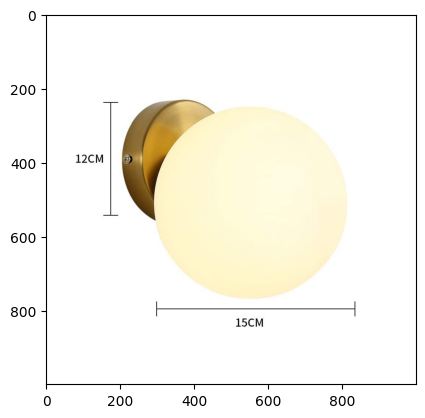

In [24]:
import random
import pytesseract

i = random.randint(0,len(df)-1)
# i = 133 , 714, 460 , 480 , 141(err) , 166(blank) , 753(rot) , 529(rot) , 362(fres bad) , 750(err)
i = 422
# goodres: 423 , 69 , 529
print(f'I: {i}')
row = df.iloc[i,:]
# for i,r in df[:10].iterrows():
img_path = df.iloc[i,0].split('/')[-1]
# img_path = '41-GUSWgzWL.jpg'
img = Image.open(f'/kaggle/input/imagestrain/sampleTrain/{img_path}')
if img:
    res3 = extract_structured_text3(np.array(img))
#     res = extract_structured_text(np.array(img))
    res2 = filterNum3(reader.readtext(img, detail=0))
#     res4 = pytesseract.image_to_string(img, lang='eng').strip()

print('_'*40)
# print(f'result: {res}')
print(f'EasyOCR rawdog: {res2}')
print(f'CRAFT: {res3}')
# print(f'PyTess: {res4.strip()}')
print(f'Entity_value: {row}')
print('_'*100)
print('_'*100)
fres = extract_value_and_unit(res3,row[2],entity_unit_map)
fres =[str(i) for i in fres]
# fres = model(res, row[1],row[2])
# print(f'fres: {model.tokenizer.decode(fres)}')
print(f'fres: {" ".join(fres)}')
plt.imshow(img)

In [31]:
fres

['7', '.', '0', ' ', 'i', 'n', 'c', 'h', 'e', 's']

In [ ]:
plt.imshow(debug_image)

In [ ]:
def load_image(image_file):
    if image_file.startswith("http://") or image_file.startswith("https://"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image
image = load_image("https://m.media-amazon.com/images/I/31rKphtJBjS.jpg")

In [ ]:
# result: [[[[638.0, 1085.0], [715.0, 1089.0], [714.0, 1113.0], [637.0, 1109.0]], [[564.0, 1054.0], [791.0, 1061.0], [790.0, 1089.0], [564.0, 1083.0]], [[567.0, 980.0], [789.0, 987.0], [788.0, 1017.0], [566.0, 1009.0]], [[574.0, 943.0], [781.0, 948.0], [780.0, 978.0], [574.0, 973.0]], [[613.0, 882.0], [747.0, 882.0], [747.0, 939.0], [613.0, 939.0]], [[578.0, 796.0], [804.0, 794.0], [804.0, 839.0], [578.0, 841.0]]]]
# Entity_value: image_link      https://m.media-amazon.com/images/I/41adaWndLM...
# group_id                                                   254449
# entity_name                                           item_volume
# entity_value                                      30.0 millilitre
# image_name                                        41adaWndLML.jpg
# Name: 3907, dtype: object
